In [1]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 86.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.0/340.0 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00

In [2]:
import numpy as np
import pandas as pd
from darts import TimeSeries
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from darts.metrics import smape
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt

        waktu  DAIHATSU    HONDA  MITSUBISHI  SUZUKI   TOYOTA
0  2021-01-01    8993.0   7231.0      9108.0  6400.0  15474.0
1  2021-02-01    9412.0   6812.0      7567.0  4600.0  14645.0
2  2021-03-01   16770.0  11350.0     13088.0  8669.0  26034.0
3  2021-04-01   15861.0   8474.0     13820.0  8100.0  22618.0
4  2021-05-01    8310.0   5832.0     10160.0  5341.0  17361.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   waktu       54 non-null     object 
 1   DAIHATSU    54 non-null     float64
 2   HONDA       54 non-null     float64
 3   MITSUBISHI  54 non-null     float64
 4   SUZUKI      54 non-null     float64
 5   TOYOTA      54 non-null     float64
dtypes: float64(5), object(1)
memory usage: 2.7+ KB


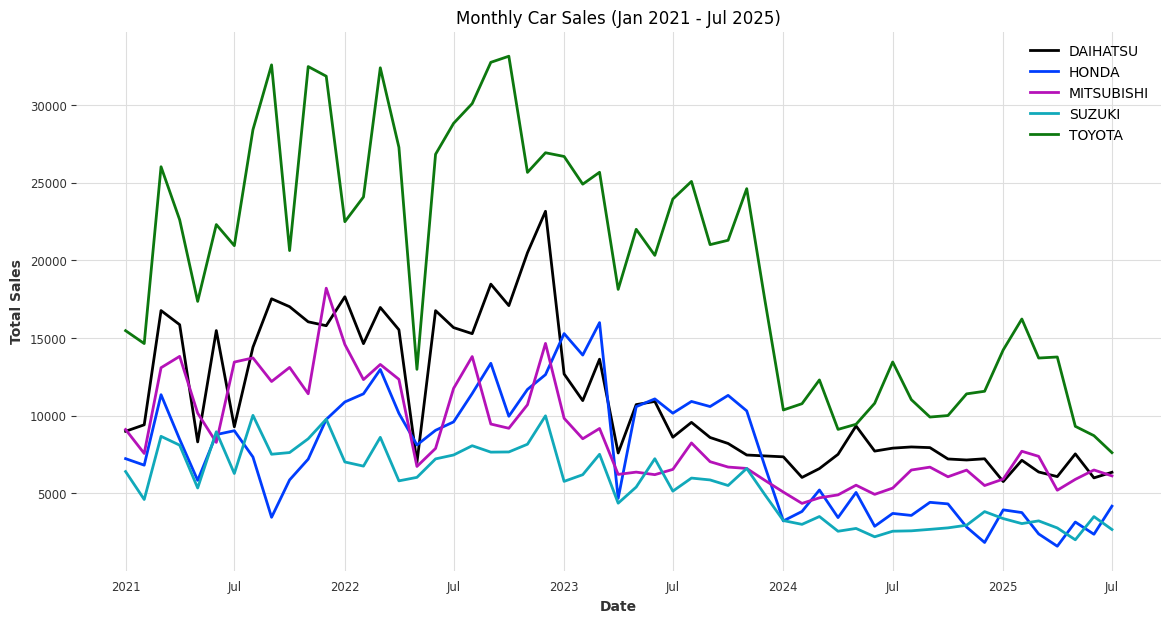

In [3]:
df = pd.read_csv("/kaggle/input/datacarsalegaikindo2021-2025/dataCarSale2021-2025.csv")
print(df.head())
df.info()

df['waktu'] = pd.to_datetime(df['waktu'])
df.set_index('waktu', inplace = True)

full_date = pd.date_range(start = df.index.min(), end = df.index.max(), freq="MS")
df = df.reindex(full_date)

df = df.interpolate(method = "linear")

series = TimeSeries.from_dataframe(df, freq='MS')

plt.figure(figsize=(14, 7))
series.plot()
plt.title('Monthly Car Sales (Jan 2021 - Jul 2025)')
plt.ylabel('Total Sales')
plt.xlabel('Date')
plt.grid(True)
plt.show()

In [4]:
df = df.reset_index().rename(columns={'index': 'waktu'})
df = df.melt(id_vars='waktu', var_name='Brand', value_name='Sales')

df['month'] = df['waktu'].dt.month
df['year'] = df['waktu'].dt.year
df['dayofweek'] = df['waktu'].dt.dayofweek
df['quarter'] = df['waktu'].dt.quarter
df['dayofyear'] = df['waktu'].dt.dayofyear

In [5]:
df = df.sort_values(by=['Brand', 'waktu'])

lags = [1, 2, 3, 6, 12]

for lag in lags:
    df[f'sales_lag_{lag}'] = df.groupby('Brand')['Sales'].shift(lag)

# print(df[df['Brand'] == 'TOYOTA'].tail())

In [6]:
window_sizes = [3, 6]

for window in window_sizes:
    df[f'sales_rolling_mean_{window}'] = df.groupby('Brand')['Sales'].rolling(window=window).mean().reset_index(level=0, drop=True)
    
    df[f'sales_rolling_std_{window}'] = df.groupby('Brand')['Sales'].rolling(window=window).std().reset_index(level=0, drop=True)

# print(df[df['Brand'] == 'TOYOTA'].tail())

In [7]:
try:
    df_ext = pd.read_csv("/kaggle/input/datacarsalegaikindo2021-2025/extFeat.csv")
    df_ext['waktu'] = pd.to_datetime(df_ext['waktu'])
    
    print("--- External features loaded successfully ---")
    print(df_ext.head())

    df_with_ext = pd.merge(df, df_ext, on='waktu', how='left')
    
    print(f"\nMissing values after merge: {df_with_ext.isnull().sum().sum()}")

    print("\n--- Merge Complete ---")
    print("Final DataFrame with all features (showing the new columns):")
    print(df_with_ext.tail())

except FileNotFoundError:
    print("File not found. Please ensure 'extFeat.csv' is uploaded to your Kaggle environment.")

df_final = df_with_ext.dropna()

--- External features loaded successfully ---
       waktu  bi_rate  inflasi_bi    IKK  inflasi_HK  harga_bensin  ritel_mom  \
0 2021-01-01     3.75        1.55   84.9        0.26          0.54       -4.3   
1 2021-02-01     3.50        1.38   85.8        0.36          0.54       -2.7   
2 2021-03-01     3.50        1.37   93.4        0.44          0.53        6.1   
3 2021-04-01     3.50        1.42  101.5        0.58          0.53       17.3   
4 2021-05-01     3.50        1.68  104.4        0.90          0.53        3.2   

   inflasi_bulanan  ritel_yoy  
0             0.26      -16.4  
1             0.10      -18.1  
2             0.08      -14.6  
3             0.13       15.6  
4             0.32       14.7  

Missing values after merge: 190

--- Merge Complete ---
Final DataFrame with all features (showing the new columns):
         waktu   Brand      Sales  month  year  dayofweek  quarter  dayofyear  \
270 2025-03-01  TOYOTA  13711.773      3  2025          5        1         6

In [8]:
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    epsilon = 1e-9
    return np.mean(numerator / (denominator + epsilon)) * 100

In [9]:
# FEATURES = [
#     'month', 'year', 'dayofweek', 'quarter', 'dayofyear',
#     'sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'sales_lag_6', 'sales_lag_12',
#     'sales_rolling_mean_3', 'sales_rolling_std_3',
#     'sales_rolling_mean_6', 'sales_rolling_std_6',
#     'bi_rate', 'inflasi', 'IKK', 'inflasi_HK'
# ]
# TARGET = 'Sales'

# df_final['Brand'] = df_final['Brand'].astype('category')
# FEATURES.append('Brand')

# df_final = df_final.sort_values(by=['waktu', 'Brand'])

# X = df_final[FEATURES]
# y = df_final[TARGET]

# n_splits = 5
# tscv = TimeSeriesSplit(n_splits=n_splits)

# brand_scores = {brand: [] for brand in df_final['Brand'].unique()}
# overall_scores = []
# fold_number = 1

# for train_index, test_index in tscv.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     model = lgb.LGBMRegressor(random_state=42)
#     model.fit(X_train, y_train)

#     predictions = model.predict(X_test)

#     results_df = pd.DataFrame({
#         'Brand': X_test['Brand'],
#         'Actuals': y_test,
#         'Predictions': predictions
#     })

#     for brand_name in results_df['Brand'].unique():
#         brand_df = results_df[results_df['Brand'] == brand_name]
#         brand_smape = smape(brand_df['Actuals'], brand_df['Predictions'])
#         brand_scores[brand_name].append(brand_smape)
#         print(f"  - SMAPE for {brand_name}: {brand_smape:.2f}%")

#     overall_fold_score = smape(results_df['Actuals'], results_df['Predictions'])
#     overall_scores.append(overall_fold_score)
#     print(f"  - Overall SMAPE for Fold {fold_number}: {overall_fold_score:.2f}%")
    
#     fold_number += 1
    
# for brand_name, scores in brand_scores.items():
#     print(f"Average SMAPE for {brand_name}: {np.mean(scores):.2f}%")

# print(f"\nOverall Average SMAPE across all folds: {np.mean(overall_scores):.2f}%")

In [10]:
# FEATURES = [
#     'month', 'year', 'dayofweek', 'quarter', 'dayofyear',
#     'sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'sales_lag_6', 'sales_lag_12',
#     'sales_rolling_mean_3', 'sales_rolling_std_3',
#     'sales_rolling_mean_6', 'sales_rolling_std_6',
#     'bi_rate', 'inflasi', 'IKK', 'inflasi_HK'
# ]
# TARGET = 'Sales'

# df_encoded = pd.get_dummies(df_final, columns=['Brand'], drop_first=True)
# brand_columns = [col for col in df_encoded.columns if 'Brand_' in col]
# FEATURES.extend(brand_columns)


# df_encoded = df_encoded.sort_values(by=['waktu'])

# X = df_encoded[FEATURES]
# y = df_encoded[TARGET]

# n_splits = 5
# tscv = TimeSeriesSplit(n_splits=n_splits)

# overall_scores = []
# fold_number = 1

# for train_index, test_index in tscv.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)

#     model = Ridge(random_state=42)
#     model.fit(X_train_scaled, y_train)

#     predictions = model.predict(X_test_scaled)

#     overall_fold_score = smape(y_test, predictions)
#     overall_scores.append(overall_fold_score)
#     print(f"  - Overall SMAPE for Fold {fold_number}: {overall_fold_score:.2f}%")
    
#     fold_number += 1
  
# print(f"\nOverall Average SMAPE across all folds: {np.mean(overall_scores):.2f}%")

/tmp/ipykernel_36/3502771717.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_lgbm['Brand'] = X_test_lgbm['Brand'].astype('category')


  - SMAPE for DAIHATSU: 17.17%
  - SMAPE for HONDA: 13.64%
  - SMAPE for MITSUBISHI: 15.00%
  - SMAPE for SUZUKI: 11.27%
  - SMAPE for TOYOTA: 11.11%
  - Overall SMAPE for Fold 1: 13.64%


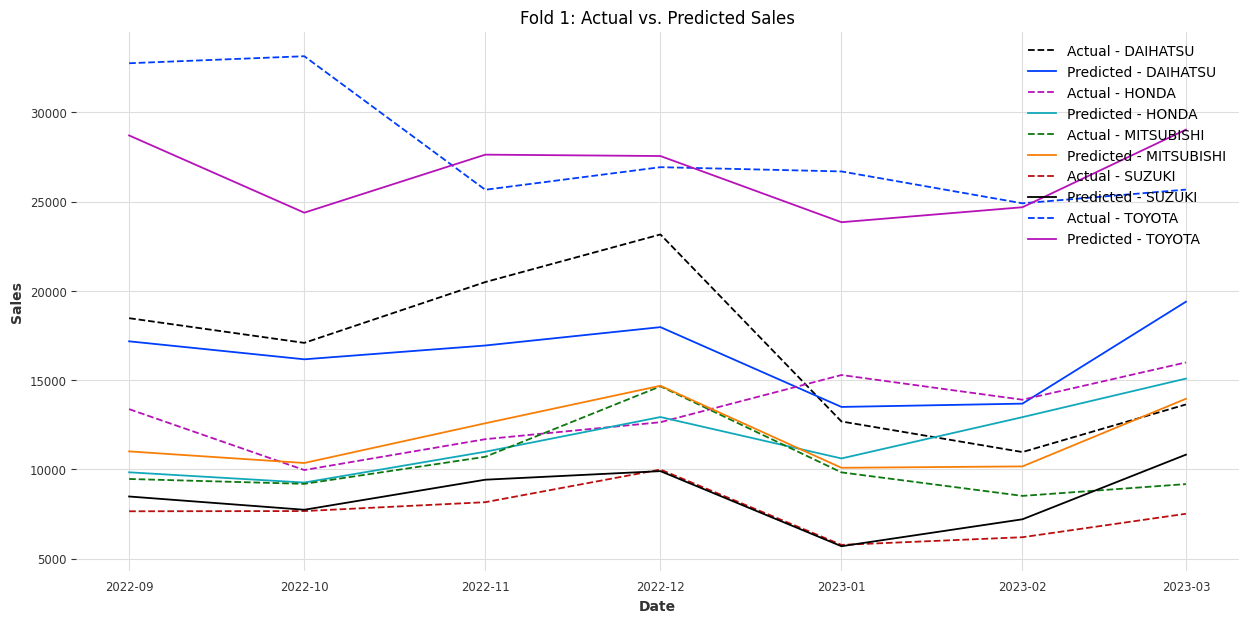

/tmp/ipykernel_36/3502771717.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_lgbm['Brand'] = X_test_lgbm['Brand'].astype('category')


  - SMAPE for DAIHATSU: 21.04%
  - SMAPE for HONDA: 17.07%
  - SMAPE for MITSUBISHI: 11.06%
  - SMAPE for SUZUKI: 8.30%
  - SMAPE for TOYOTA: 8.14%
  - Overall SMAPE for Fold 2: 13.12%


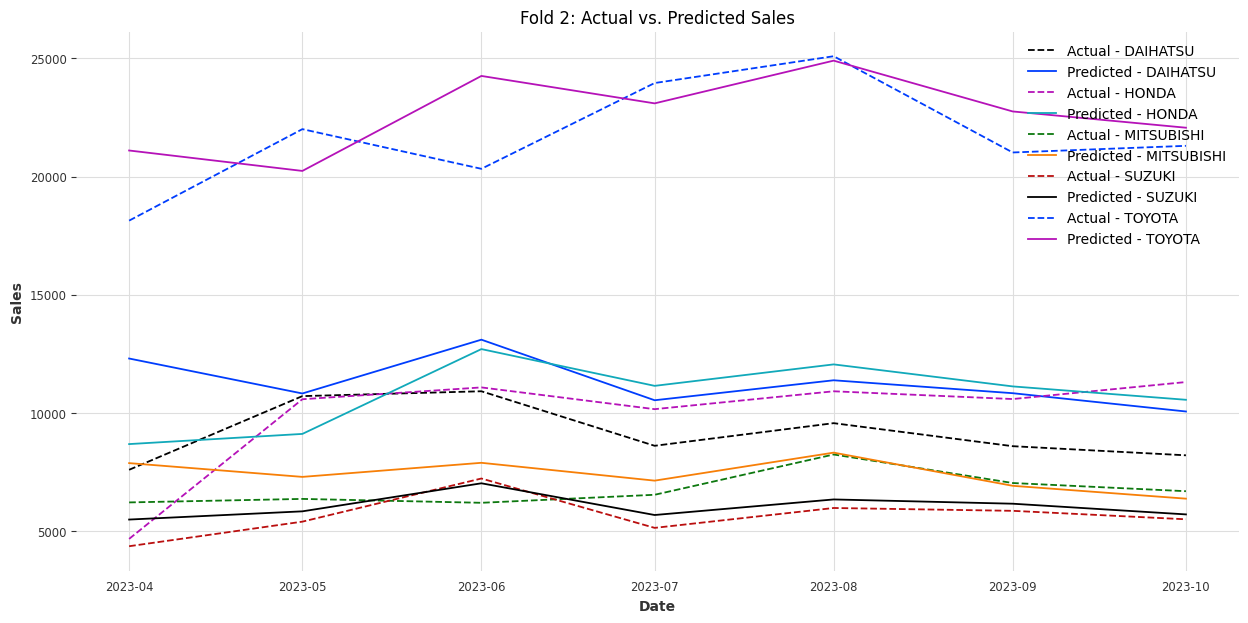

/tmp/ipykernel_36/3502771717.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_lgbm['Brand'] = X_test_lgbm['Brand'].astype('category')


  - SMAPE for DAIHATSU: 12.68%
  - SMAPE for HONDA: 25.31%
  - SMAPE for MITSUBISHI: 7.70%
  - SMAPE for SUZUKI: 10.84%
  - SMAPE for TOYOTA: 22.24%
  - Overall SMAPE for Fold 3: 15.75%


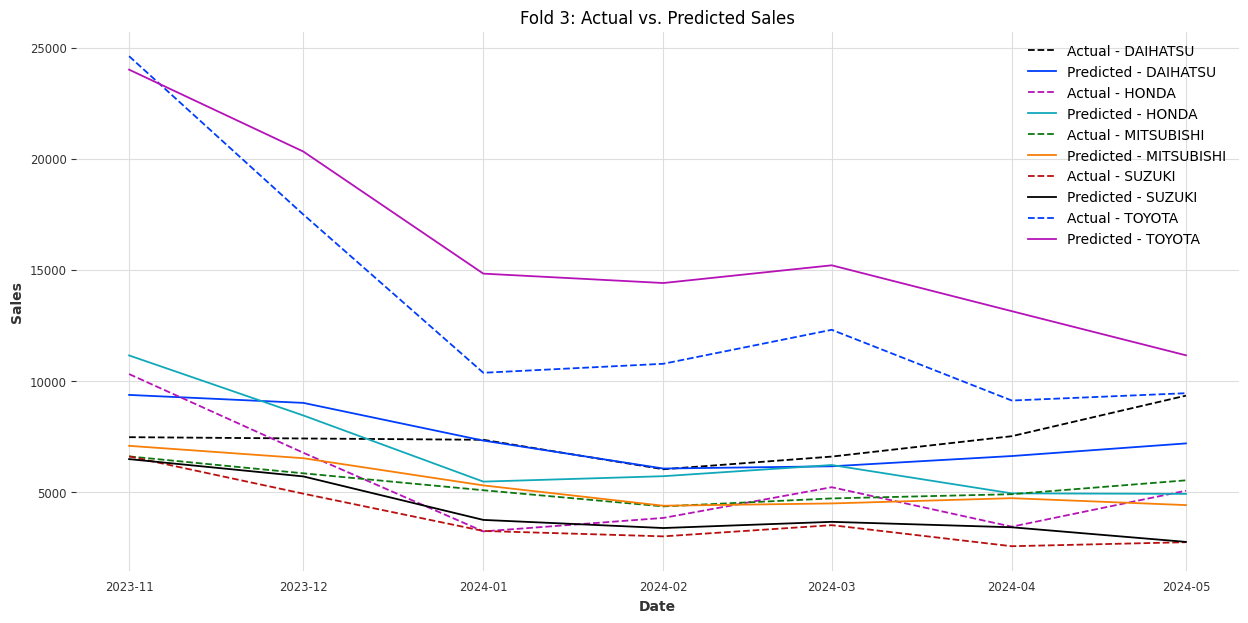

/tmp/ipykernel_36/3502771717.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_lgbm['Brand'] = X_test_lgbm['Brand'].astype('category')


  - SMAPE for DAIHATSU: 6.46%
  - SMAPE for HONDA: 12.55%
  - SMAPE for MITSUBISHI: 13.76%
  - SMAPE for SUZUKI: 11.26%
  - SMAPE for TOYOTA: 6.18%
  - Overall SMAPE for Fold 4: 10.04%


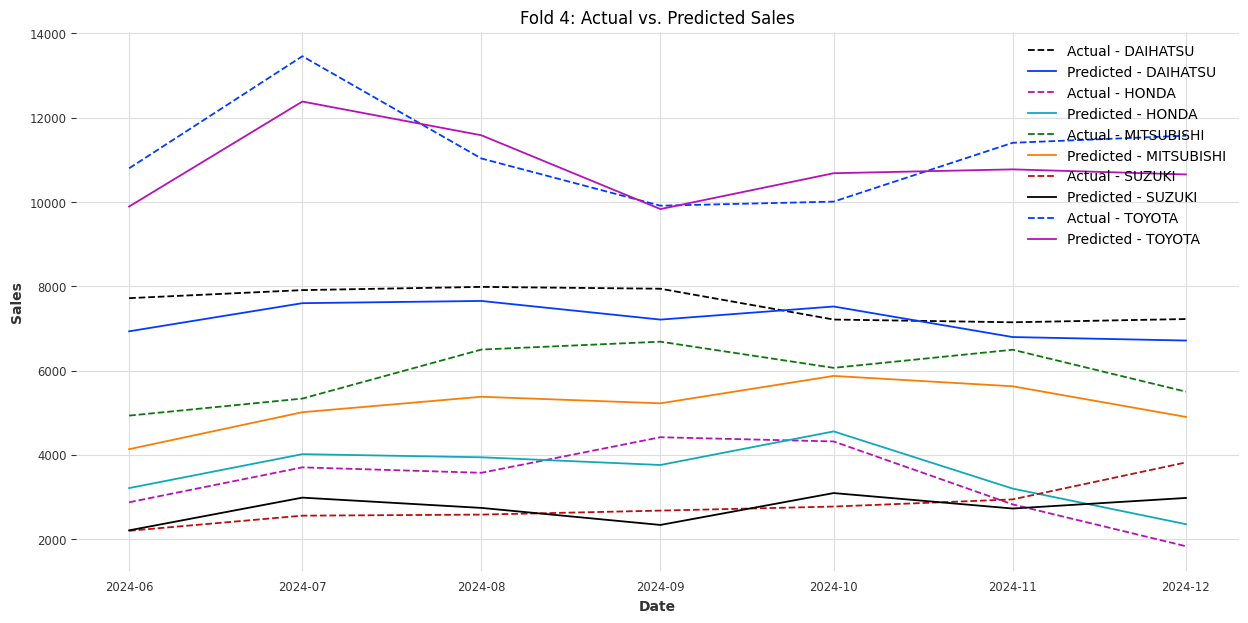

/tmp/ipykernel_36/3502771717.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_lgbm['Brand'] = X_test_lgbm['Brand'].astype('category')


  - SMAPE for DAIHATSU: 6.27%
  - SMAPE for HONDA: 18.84%
  - SMAPE for MITSUBISHI: 12.30%
  - SMAPE for SUZUKI: 17.83%
  - SMAPE for TOYOTA: 11.33%
  - Overall SMAPE for Fold 5: 13.31%


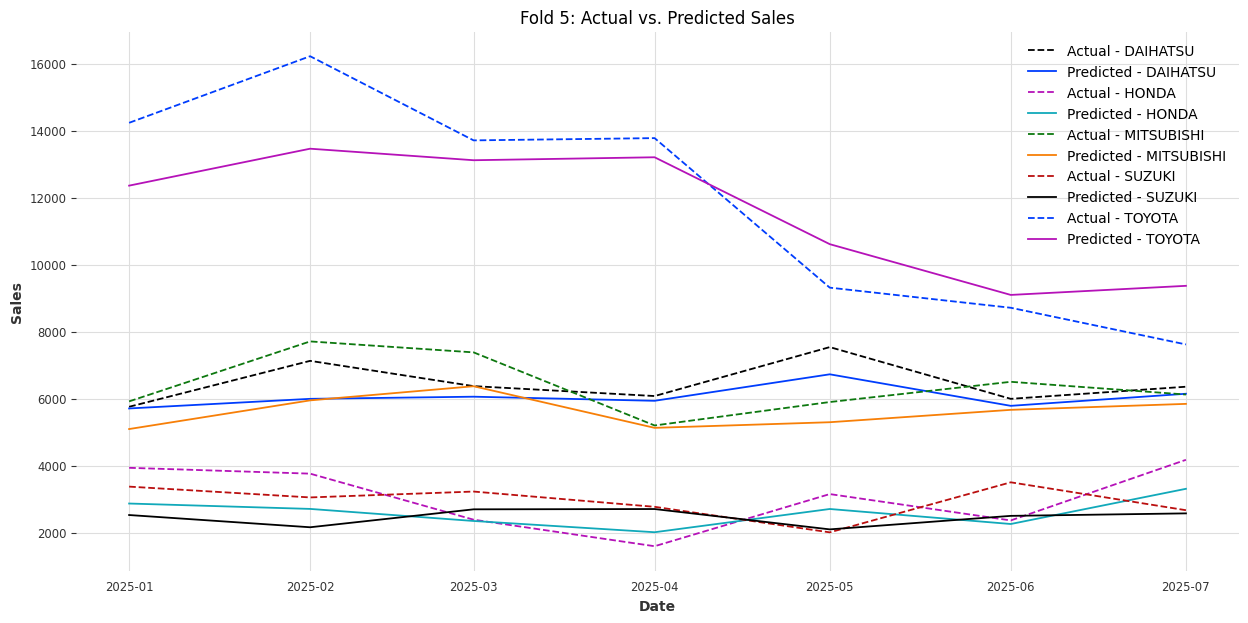

Average SMAPE for DAIHATSU: 12.72%
Average SMAPE for HONDA: 17.48%
Average SMAPE for MITSUBISHI: 11.96%
Average SMAPE for SUZUKI: 11.90%
Average SMAPE for TOYOTA: 11.80%

Overall Average SMAPE for Ensemble Model: 13.17%


In [28]:
FEATURES = [
    'month', 'year', 'dayofweek', 'quarter', 'dayofyear',
    'sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'sales_lag_12',
    'sales_rolling_mean_3', 'sales_rolling_std_3',
    'sales_rolling_mean_6', 'sales_rolling_std_6',
    'bi_rate', 'IKK', 'inflasi_bulanan', 'ritel_yoy'
]
TARGET = 'Sales'

df_final = df_final.sort_values(by=['waktu', 'Brand'])

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

brand_scores = {brand: [] for brand in df_final['Brand'].unique()}
overall_scores = []
fold_number = 1

for train_index, test_index in tscv.split(df_final):
    train_fold = df_final.iloc[train_index]
    test_fold = df_final.iloc[test_index]

    #LightGBM
    lgbm_features = FEATURES + ['Brand']
    X_train_lgbm = train_fold[lgbm_features].copy()
    y_train_lgbm = train_fold[TARGET].copy()
    X_test_lgbm = test_fold[lgbm_features]
    
    X_train_lgbm['Brand'] = X_train_lgbm['Brand'].astype('category')
    X_test_lgbm['Brand'] = X_test_lgbm['Brand'].astype('category')

    lgbm = lgb.LGBMRegressor(random_state=42, verbosity=-1)
    lgbm.fit(X_train_lgbm, y_train_lgbm)
    preds_lgbm = lgbm.predict(X_test_lgbm)

    # Ridge
    train_fold_encoded = pd.get_dummies(train_fold, columns=['Brand'], drop_first=True)
    test_fold_encoded = pd.get_dummies(test_fold, columns=['Brand'], drop_first=True)
    
    brand_cols = [col for col in train_fold_encoded.columns if 'Brand_' in col]
    ridge_features = FEATURES + brand_cols
    
    X_train_ridge = train_fold_encoded[ridge_features]
    y_train_ridge = train_fold_encoded[TARGET]
    X_test_ridge = test_fold_encoded[ridge_features]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_ridge)
    X_test_scaled = scaler.transform(X_test_ridge)

    ridge = Ridge(random_state=42)
    ridge.fit(X_train_scaled, y_train_ridge)
    preds_ridge = ridge.predict(X_test_scaled)

    #Ensemble
    ensemble_preds = 0.8 * preds_ridge + 0.2 * preds_lgbm

    #Evaluation
    results_df = pd.DataFrame({
        'waktu': test_fold['waktu'],
        'Brand': test_fold['Brand'],
        'Actuals': test_fold[TARGET],
        'Predictions': ensemble_preds
    })

    for brand_name in results_df['Brand'].unique():
        brand_df = results_df[results_df['Brand'] == brand_name]
        brand_smape = smape(brand_df['Actuals'], brand_df['Predictions'])
        brand_scores[brand_name].append(brand_smape)
        print(f"  - SMAPE for {brand_name}: {brand_smape:.2f}%")
    
    overall_fold_score = smape(results_df['Actuals'], results_df['Predictions'])
    overall_scores.append(overall_fold_score)
    print(f"  - Overall SMAPE for Fold {fold_number}: {overall_fold_score:.2f}%")

    #Visualization
    plt.figure(figsize=(15, 7))
    for brand in results_df['Brand'].unique():
        plot_df = results_df[results_df['Brand'] == brand]
        plt.plot(plot_df['waktu'], plot_df['Actuals'], '--', label=f'Actual - {brand}')
        plt.plot(plot_df['waktu'], plot_df['Predictions'], '-', label=f'Predicted - {brand}')
    
    plt.title(f'Fold {fold_number}: Actual vs. Predicted Sales')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    fold_number += 1

for brand_name, scores in brand_scores.items():
    print(f"Average SMAPE for {brand_name}: {np.mean(scores):.2f}%")

print(f"\nOverall Average SMAPE for Ensemble Model: {np.mean(overall_scores):.2f}%")